# __SVM-MLP-Classifier-Comparisons__
### Tan Jian An
***
Given a two-class pattern classification problem, two neural network classifiers, namely Gaussian kernel SVM classifier and MLP neural network classifier are trained using the training data, and the class labels of the testing data is predicted. 
## 0. Import packages and initialize input data
The input data is imported from the original .mat file using the loadmat function from scipy.io library. The train dataset is imported as X, train class label as y and the test dataset as test.

In [1]:
import os
import scipy.io as sio
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from skorch import NeuralNetClassifier
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from pathlib import Path
from IPython.display import Image
from sklearn.neural_network import MLPClassifier
import time



data_train = sio.loadmat("data_train (1).mat")
label_train = sio.loadmat("label_train(2).mat")
data_test = sio.loadmat("data_test(2).mat")


data_train = [[element for element in upperElement] \
              for upperElement in data_train['data_train']]
label_train = [[element for element in upperElement] \
               for upperElement in label_train['label_train']]
data_test = [[element for element in upperElement] \
              for upperElement in data_test['data_test']]


data_col = [i + 1 for i in range(len(data_train[0]))]
classes = [-1, 1]
NUM_INPUT = len(data_col)


X = pd.DataFrame(data_train, columns=data_col)
y = pd.DataFrame(label_train, columns = ['output'])
test = pd.DataFrame(data_test, columns=data_col)

## 1. Gaussian Kernel SVM Classifier
A kernel SVM classifier is developed, with Gaussian kernel function being used. The parameters of the classifier is obtained using exhaustive search method.
### 1.1 Hyperparameter Tuning
The SVM model is developed using the C-Support Vector Classification (SVC) class provided by Sci-Kit Learn. Two of the parameters that need to be configured in the SVC class are 'C' and 'gamma' respectively. 'C' is a regularization parameter and is inversely proportional to the strength of the regularization. The penalty is a squared l2 penalty [1]; 'rbf' or Gaussian radial basis function is chosen as the kernel type. The kernel function is given by $exp(-\gamma||x - x'||)$, where $\gamma$ is to be defined by the parameter 'gamma'[2]. 

As 'C' and 'gamma' are parameters that cannot be learned directly within the SVM estimator, GridSearchCV by Sci-Kit Learn is used to find the optimized values for 'C' and 'gamma'. GridSearchCV is an exhaustive search method over a defined parameter value range to look for the best suited value for the estimator. It will fit all the possible combinations of parameter values from the given range and fit them on the dataset. Then the accuracy score from each combination is evaluated and the best combination is selected.

Hyperparameter tuning could be done using the entire train dataset. However, there is a possibility that the values obtained could be a result of overfitting on the train set as the parameters are tuned until the estimator obtains the best result. In other words, the information regarding the validation set could have leaked into the model, resulting in a biased performance evaluation. To reduce the chances of getting overfitted results,  the imported training data is randomly split into train set X_train, y_train and test set X_test, y_test using the train_test_split helper function with a 3:1 ratio, such that only 2/3 of the data are chosen as the training data and will be used to during the hyperparameter tuning.

In [2]:
# Spit the train dataset to train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Parameters to be tuned
params = {
    'C': np.arange(1, 21, 1),
    'gamma': ['scale', 'auto'], 
    'kernel': ['rbf']
}

# Exhaustive search
gs = GridSearchCV(SVC(), params, refit=True, scoring='accuracy', n_jobs=-1)
gs.fit(X_train,y_train)

C:\Users\Jian An Tan\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
             scoring='accuracy')

As depicted in the code below, 'C' with value of 5 and 'gamma' with the 'scale' option produce the most accurate result. As such, these parameter values will be adopted.

In [17]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# review top 5 results and parameters associated
report(gs.cv_results_,5)

Model with rank: 1
Mean validation score: 0.946 (std: 0.023)
Parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.946 (std: 0.023)
Parameters: {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.946 (std: 0.023)
Parameters: {'C': 7, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.946 (std: 0.023)
Parameters: {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 5
Mean validation score: 0.946 (std: 0.047)
Parameters: {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}



### 1.2 StratifiedKFold Cross Validation
Even though some measures are taken to address the overfitting problem, there is still a risk that the best parameter values obtained from the exhaustive search methods come from a overfitted model. <br>

To evaluate the performance of the model in a more holistic manner, cross-validation is used. The training data is divided into k number of smaller sets. The model is then trained using k-1 sets of data while the remaining set is used for validation to evaluate the performance. For classification problems, the accuracy score is used as the performance measure. In k-fold cross-validation, the model is validated k times, using different sets of data as training set on each iteration [3]. The performance computed in each loop is then summed and averaged to obtain the overall performance of the model, as depicted in the figure below.

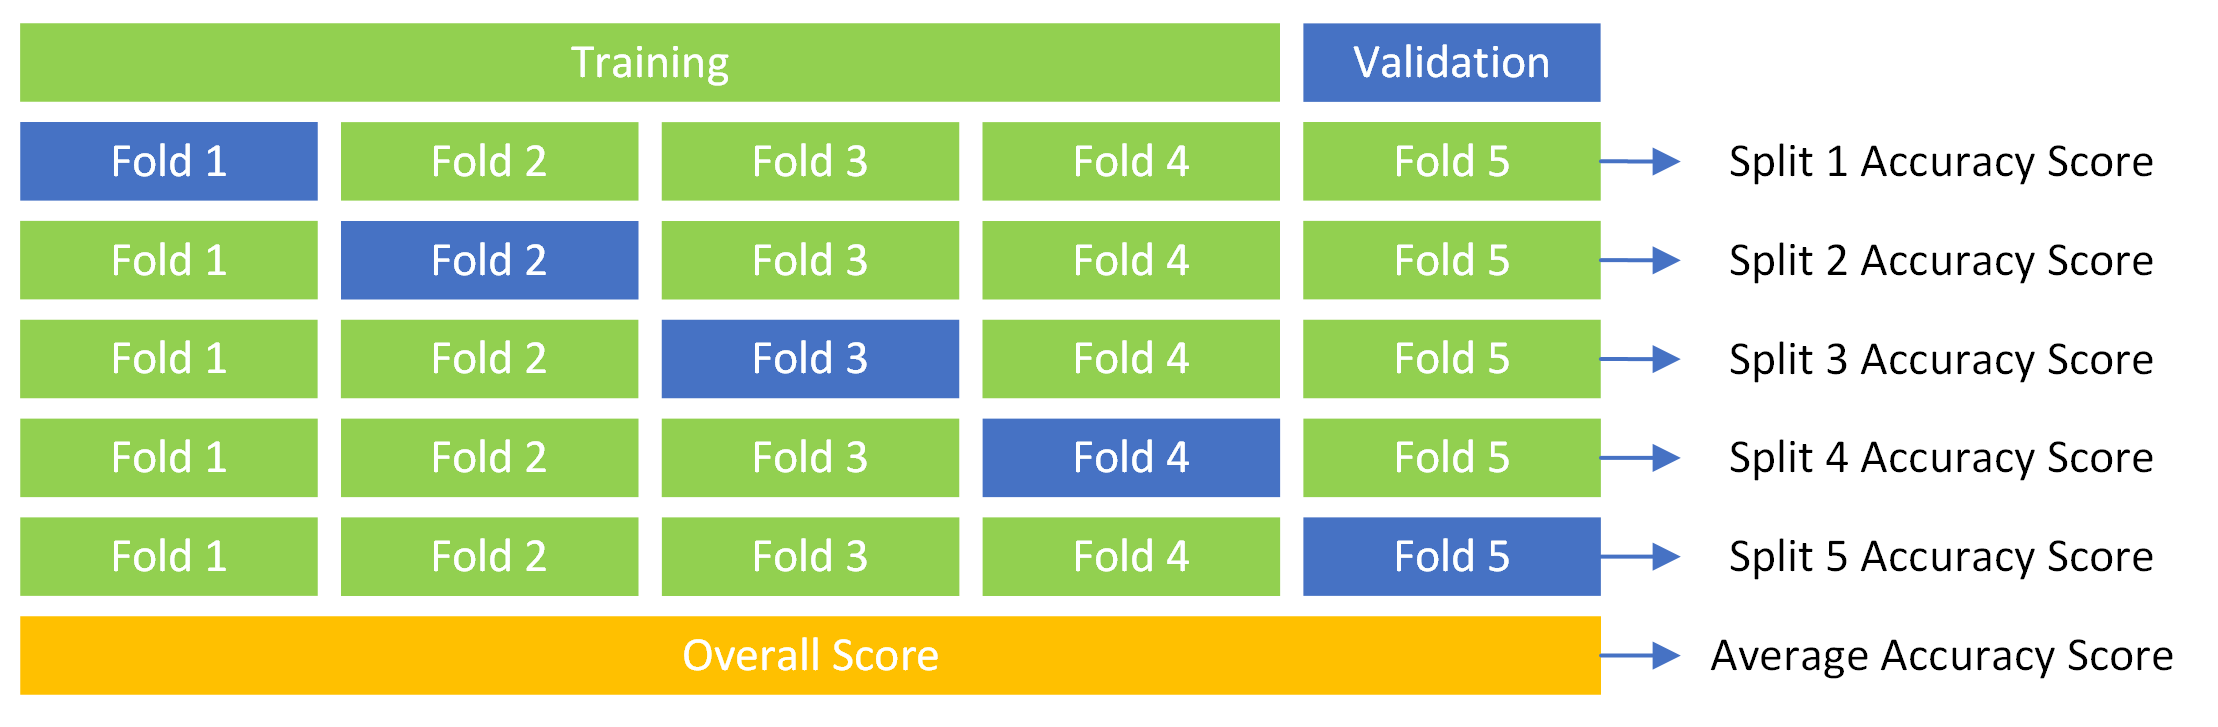

In [3]:
Image(filename='Cross Validation.png', width=800)

As the target classes in some of the classification problems could be distributed in an imbalance manner, stratified sampling is used to make sure that after the data is split into train and validation fold, the frequency of the relative classes is approximately the same as the complete data. For example, since there are two class labels for this dataset, there should be approximately 50% chance for each class label to appear in each fold.<br>

The StratifiedKFold helper function is used to split the data into N folds, each containing approximately the same distribution of samples of each target as the complete data [2]. In this case, the data is split into 5 folds.

In [30]:
# Prepare cross validation splits
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=2022)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

fold_idx = dict()

for i, (train_idx, val_idx) in enumerate(skf.split(X.index, y)):
    fold_idx[i] = (train_idx, val_idx)

fold_results = dict()

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    #random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

fold_results = dict()
avg_score = []
cm_overall = np.zeros((2, 2))
for fold_num, (train_idx, val_idx) in fold_idx.items():
    print(f'fold: {fold_num + 1}')
    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()
    
    X_test = X.iloc[val_idx].copy()
    y_test = y.iloc[val_idx].copy()

    svm = SVC(C=5, gamma='scale', kernel="rbf") 

    # fit classifier to training set
    svm.fit(X_train,y_train.values.ravel())

    y_pred=svm.predict(X_test)
    # Accuracy score
    a_s = accuracy_score(y_test, y_pred)
    # Confusion matrix
    c_m = confusion_matrix(y_test, y_pred)
    cm_overall += c_m
    print('Model accuracy score: {0:0.4f}'. format(a_s))
    avg_score.append(a_s)
    
print(f'Average accuracy is: {np.mean(avg_score)}, std deviation: {np.std(avg_score)}')
print(f'Confusion matrix is: \n{cm_overall}')

fold: 1
Model accuracy score: 0.9091
fold: 2
Model accuracy score: 0.9545
fold: 3
Model accuracy score: 0.9242
fold: 4
Model accuracy score: 0.9848
fold: 5
Model accuracy score: 0.9848
Average accuracy is: 0.9515151515151515, std deviation: 0.030903148567229023
Confusion matrix is: 
[[103.  13.]
 [  3. 211.]]


### 1.3 Visualization of SVM Decision Surface

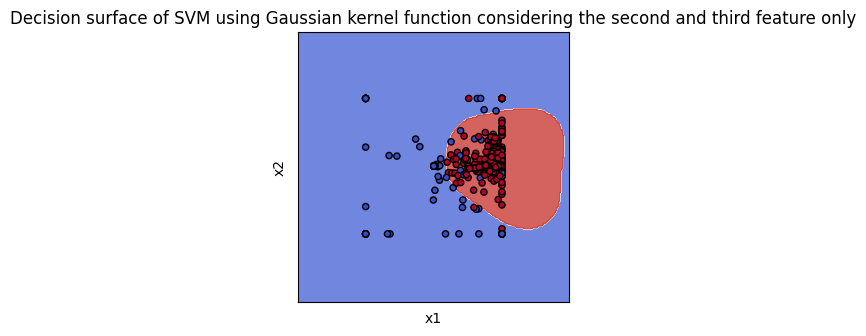

In [8]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
clf = svm.fit(X.iloc[:, 1:3],y.values.ravel())
fig, ax = plt.subplots(figsize=(3.5, 3.5))
# title for the plots
title = ('Decision surface of SVM using \
Gaussian kernel function considering the second and third feature only')
# Set-up grid for plotting.
X0, X1 = X.iloc[:, 1], X.iloc[:, 2]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, 
           X1, 
           c=y.values.ravel(), 
           cmap=plt.cm.coolwarm, 
           s=20, 
           edgecolors="k")
ax.set_ylabel("x2")
ax.set_xlabel("x1")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

## 2. Multi-layer Perceptron (MLP) Neural Network Classifier
An MLP neural network with one hidden layer is first being  investigated, followed by MLP neural network with two hidden layers. 


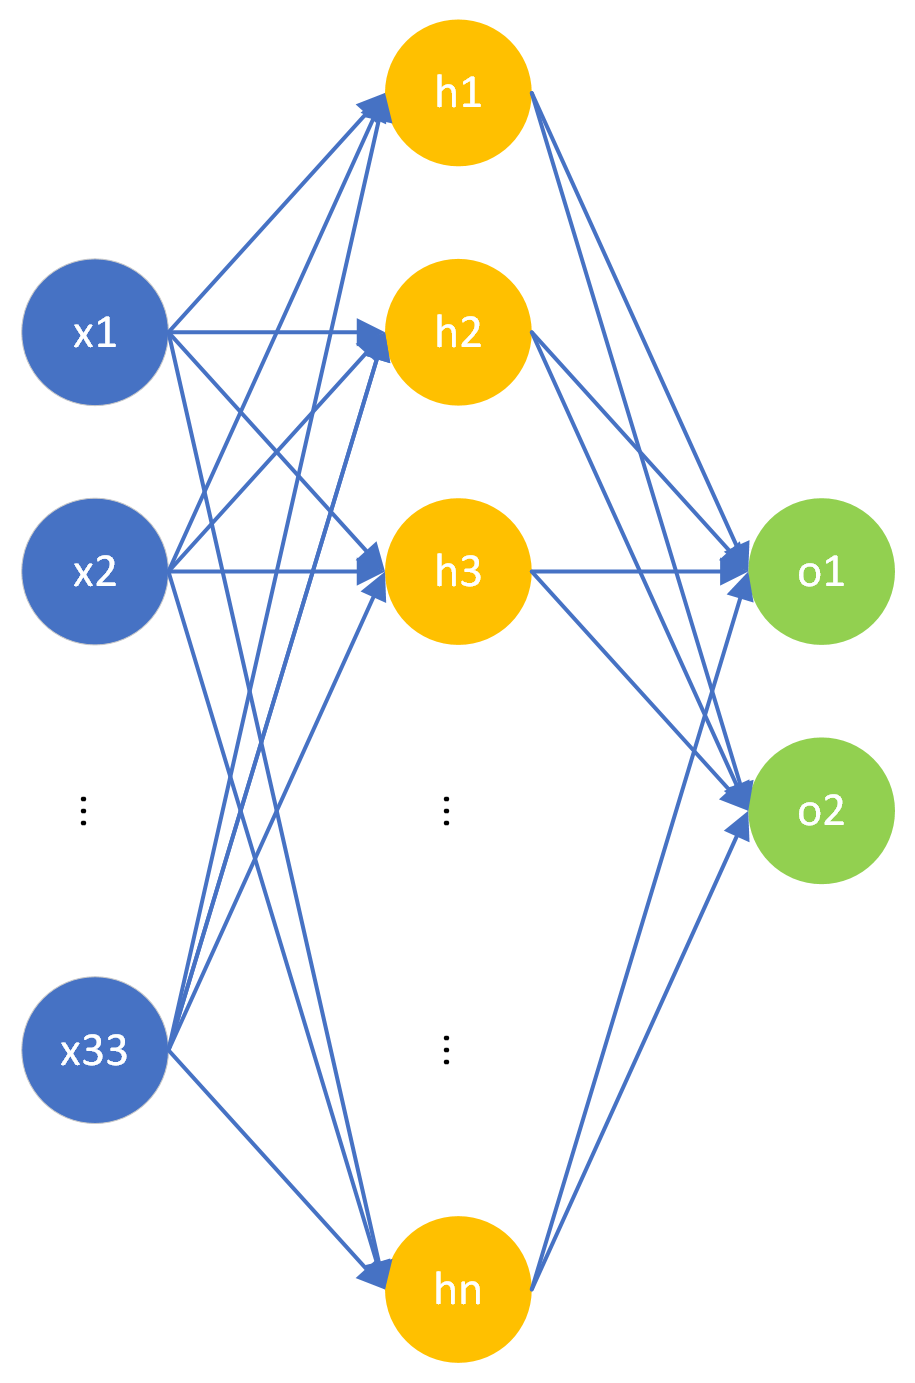

In [ ]:
Image(filename='MLP.png', width=300)

### 2.1 MLP with 1 hidden layer
Unlike the svm.SVC model developed in the previous section, where only two parameters need to be tuned, the total number of parameters that need to be tuned for  the MLP neural network classifier are significantly higher. These parameters include the total number of epochs, the number of hidden layers, the number of neurons in each hidden layer, the type of activation functions and learning rate. As such, it will be difficult for the hyper-parameter tuning to be implemented as it is too computationally expensive for exhaustive search to take place. Instead, trial and error approach is adopted to find out the best values for the parameters. <br>

The optimized values for number of epochs, number of hidden neurons, and learning rate are 2000, 470, ReLU 0.03 respectively. For the hidden layer, ReLU function is used as the activation function. 

In [10]:
NUM_OUTPUT = 2

class MLP_1HiddenLayer(nn.Module): 
  def __init__(self, numInput, num_hidden_1=0, act='relu'): 
    super(MLP_1HiddenLayer, self).__init__() 
    self.fc1 = nn.Linear(numInput , num_hidden_1) 
    self.fc2 = nn.Linear(num_hidden_1 , NUM_OUTPUT) 
    if act == 'relu':
        self.act = nn.ReLU()
    elif act == 'leakyrelu':
        self.act = nn.LeakyReLU()
    elif act == 'sigmoid':
        self.act = nn.Sigmoid()
    elif act == 'elu':
        self.act = nn.ELU()
     
  def forward(self,x): 
    x = self.act(self.fc1(x)) 
    x = self.fc2(x)
    return x

#### 2.1.1 StratifiedKFold Cross Validation
##### Criterion
Since the given dataset is a classification problem, the Cross Entropy Loss criterion is used to compute the gradient. This criterion computes the cross entropy loss between the prediction and its corresponding target [5]. The loss for each class is given by: $$Loss, L=[l_{1}, ..., l_{N}]^{T},$$   $$l_{n}=-\sum\limits _{c=1} ^{C}w_{c}log \frac{exp(x_{n, c})} {\sum\limits _{c=1} ^{C} exp(x_{n, i})}y_{n, c}$$ where $x$ is the predicted value, $y$ is the target value, $w$ is the weight, $C$ refers to the number of class labels and N is the dimension of the minibatch. The mean of the losses across the batch is then computed: $$l(x, y)=\frac{\sum\limits _{n=1} ^{N}l_{n}}{N}$$
##### Optimizer
The optimizer is the algorithm that performs optimization on the gradient descent. The Stochastic gradient descent (SGD) is used as the optimizer. SGD takes lesser computational time because unlike batch gradient descent, where gradients for similar examples for each parameter update are recomputed, SGD performs one update each time. SGD also performs high variance frequent updates and causes high fluctuations in the objective functions. This allows SGD to jump out of local minima and potentially finds a more optimal solution. However, this could also cause SGD to overshoot. Nevertheless, this can be resolved by slowly reducing the learning rate if the loss convergence to the minimum cannot be achieved.

Average accuracy is: 0.9393939393939394, std deviation: 0.028747978728803466
Confusion matrix is: 
[[ 99.  17.]
 [  3. 211.]]


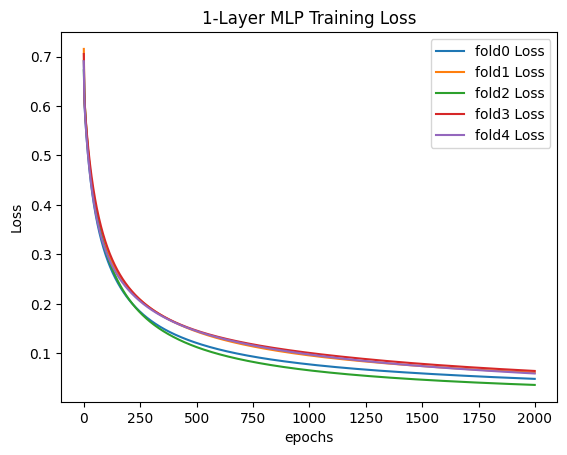

In [29]:
NUM_EPOCHS = 2000
NUM_HIDDEN1 = 470 
ACT = 'relu'
LR = 0.03

# make random numbers reproducible
set_seed(0)
fold_results = dict()
avg_score = []
cm_overall = np.zeros((2, 2))

for fold_num, (train_idx, val_idx) in fold_idx.items():
    #print(f'fold: {fold_num + 1}')
    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_train.loc[y_train.output == -1, 'output'] = 0
    
    X_test = X.iloc[val_idx].copy()
    y_test = y.iloc[val_idx].copy()

    # Convert training data to torch tensor
    train_X = torch.FloatTensor(X_train.to_numpy()).to(device) 
    test_X = torch.FloatTensor(X_test.to_numpy()).to(device) 
    y_train = torch.LongTensor(y_train.to_numpy()).squeeze().to(device) 
    
    model = MLP_1HiddenLayer(NUM_INPUT, NUM_HIDDEN1, ACT).to(device) 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    
    fold_train_loss = []
    fold_val_loss = []
    fold_accuracy = []
    
    for epoch in range(NUM_EPOCHS): 
        output = model(train_X) 
        loss = criterion(output, y_train) 
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        fold_train_loss.append(loss.detach().numpy())
        
    predict_out = model(test_X)
    _, y_pred = torch.max(predict_out, 1)
    y_pred = [classes[y_pred.numpy()[i]] for i in range(len(y_pred))]
    y_test = y_test.to_numpy().squeeze()
    avg_score.append(accuracy_score(y_test, y_pred))
    # Confusion matrix
    c_m = confusion_matrix(y_test, y_pred)
    cm_overall += c_m
    plt.plot(fold_train_loss, label=f'fold{fold_num} Loss')

print(f'Average accuracy is: {np.mean(avg_score)}, std deviation: {np.std(avg_score)}')
print(f'Confusion matrix is: \n{cm_overall}')
plt.title('1-Layer MLP Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

### 2.2 MLP with 2 hidden layers
Similar to the 1-layer MLP neural network, the parameters are fine-tuned through trial and error. <br>
The optimized values for number of epochs, number of neurons for hidden layer 1, number of neurons for hidden layer 2, and learning rate are 2000, 470, 470, and 0.03 respectively. ReLU function is used as the activation function for the hidden layer.
#### 2.1.2 StratifiedKFold Cross Validation

In [32]:
class MLP_2HiddenLayer(nn.Module): 
  def __init__(self, numInput, num_hidden_1=0, num_hidden_2=0, act='relu'): 
    super(MLP_2HiddenLayer, self).__init__() 
    self.fc1 = nn.Linear(numInput , num_hidden_1)   
    self.fc2 = nn.Linear(num_hidden_1 , num_hidden_2) # Hidden layer 1 
    self.fc3 = nn.Linear(num_hidden_2 , NUM_OUTPUT) # Hidden layer 2
    if act == 'relu':
        self.act = nn.ReLU()
    elif act == 'leakyrelu':
        self.act = nn.LeakyReLU()
    elif act == 'sigmoid':
        self.act = nn.Sigmoid()
    elif act == 'elu':
        self.act = nn.ELU()
  def forward(self,x): 
    x = self.act(self.fc1(x)) 
    x = self.act(self.fc2(x)) 
    x = self.fc3(x)
    return x

Average accuracy is: 0.9363636363636363, std deviation: 0.026067652324371623
Confusion matrix is: 
[[100.  16.]
 [  5. 209.]]


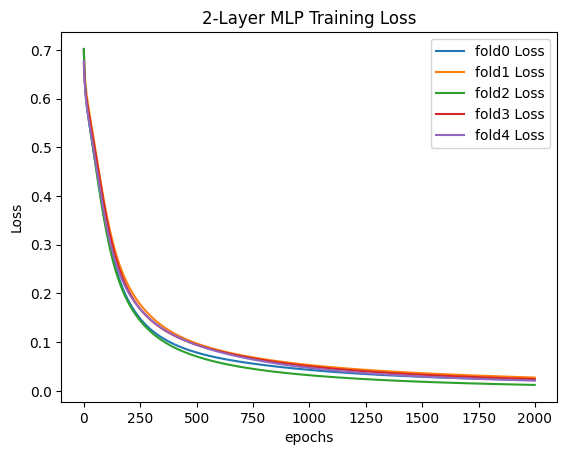

In [33]:
NUM_EPOCHS = 2000
NUM_HIDDEN1 = 470 
NUM_HIDDEN2 = 470
ACT = 'relu'
LR = 0.03

set_seed(0)
fold_results = dict()
avg_score = []
cm_overall = np.zeros((2, 2))

for fold_num, (train_idx, val_idx) in fold_idx.items():
    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_train.loc[y_train.output == -1, 'output'] = 0
    
    X_test = X.iloc[val_idx].copy()
    y_test = y.iloc[val_idx].copy()
    
    # Convert training data to torch tensor
    train_X = torch.FloatTensor(X_train.to_numpy()).to(device) 
    test_X = torch.FloatTensor(X_test.to_numpy()).to(device) 
    y_train = torch.LongTensor(y_train.to_numpy()).squeeze().to(device) 
    
    model = MLP_2HiddenLayer(NUM_INPUT, NUM_HIDDEN1, NUM_HIDDEN2, ACT).to(device) 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    
    fold_train_loss = []
    
    for epoch in range(NUM_EPOCHS): 
        optimizer.zero_grad() 
        output = model(train_X) 
        loss = criterion(output, y_train) 
        loss.backward() 
        optimizer.step() 
        
        fold_train_loss.append(loss.detach().numpy())
            
    predict_out = model(test_X)
    _, y_pred = torch.max(predict_out, 1)
    y_pred = [classes[y_pred.numpy()[i]] for i in range(len(y_pred))]
    y_test = y_test.to_numpy().squeeze()
    avg_score.append(accuracy_score(y_test, y_pred))
    
    # Confusion matrix
    c_m = confusion_matrix(y_test, y_pred)
    cm_overall += c_m
    plt.plot(fold_train_loss, label=f'fold{fold_num} Loss')

print(f'Average accuracy is: {np.mean(avg_score)}, std deviation: {np.std(avg_score)}')
print(f'Confusion matrix is: \n{cm_overall}')
plt.title('2-Layer MLP Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

<br><br><br><br><br><br><br><br><br>
## 3. Comparisons and discussions of the performance of the two classifiers on the training data.
The performance of the two classifiers are evaluated based on the results obtained from cross validation. The evaluation criteria include the total time taken for the training of 5 split dataset to be completed, the mean accuracy score across 5 training folds as well as the standard deviation. <br>

The table below shows the three models as discussed previously and their corresponding results:<br>



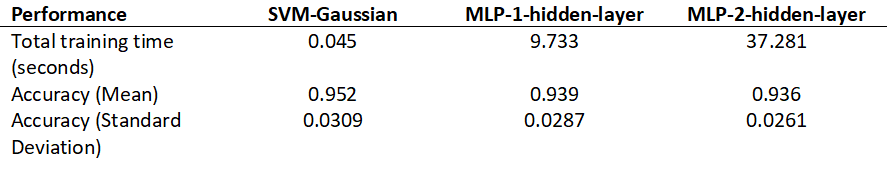

In [6]:
Image(filename='Performance.png', width=700)

##### Training time 
Under the same computational setup, the training time of the SVM classifier with Gaussian kernal is the shortest at 0.045 seconds. The MLP classifier with 1 hidden layer took approximately 10 seconds to complete the training. Furthermore, the training time of the MLP classifier with 2 hidden layers is circa 3 times longer than its 1-layer counterpart. <br>

From the results, the SVM classifier with Gaussian kernel has a more superior performance in terms of training time compared to the MLP classifiers. For MLP classifiers, the computational time is directly proportional to the number of hidden layers. As such, the time taken by the 2-layer MLP is much longer than that of the 1-layer MLP.<br><br>

##### Accuracy score
The classifiers are also evaluated based on the accuarcy of their predictions. The accuracy score is computed using the accuracy_score funciton provided by Scikit Learn. The accuracy score is computed using the formula given by: <br> 
$$
accuracy(y, \hat{y}) = \frac{1}{n_{samples}}\sum\limits _{i=0} ^{n_{samples}-1}1(\hat{y}_{i} = y_{i})
$$
where $y$ is the true class of the given data. $\hat{y}$ is the predicted class [4]. $1(x)$ is the indicator function where $1(x)$=1 if $y=\hat{y}$ and 0 otherwise. The function has a minimum value of 0 and a maximum value of 1.<br>
The accuracy is computed by summing up the accuracy score across all 5 folds and then dividing it by 5. As such, the mean score of the classifier can be obtained.<br>

In general, all classifiers produced good accuracy score. SVM with Gaussian kernel classifier has the best accuracy score at 0.952, followed by 1-layer MLP classifier at 0.939 and 2-layer MLP classifier at 0.936. The standard deviations are 0.039, 0.0287 and 0.0261 respectively. <br>
##### Confusion Matrix
The confusion matrix provides details on the accuracy of each model on different classes, as shown in the image below:


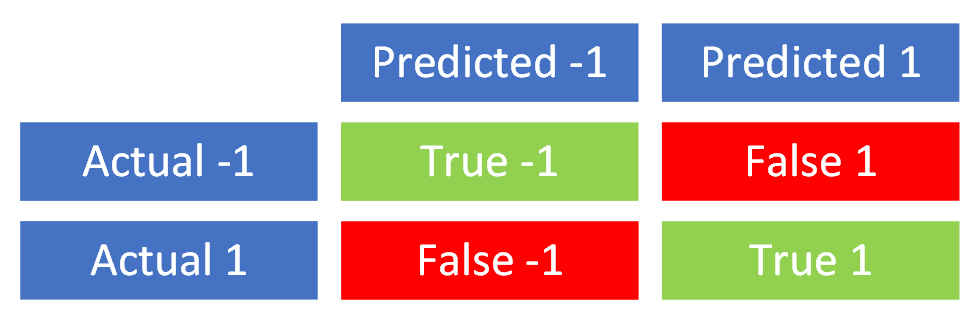

In [45]:
Image(filename='confusion_matrix.png', width=400)

The confusion matrix of the SVM classifier with Gaussian kernel is $\begin{bmatrix}103 & 13 \\ 3 & 211\end{bmatrix}$, which means that the SVM classifier managed to predict 103 out of 116 data with class label -1 and 211 out of 214 data with class label 1 correctly. In comparison the SVM classifier, the confusion matrices for MLP classifier with 1 hidden layer and 2 hidden layer are $\begin{bmatrix}99 & 17 \\ 3 & 211\end{bmatrix}$ and $\begin{bmatrix}100 & 16 \\ 5 & 209\end{bmatrix}$ respectively.<br>

Given the size of the training data, it can be concluded that for small dataset, SVM classifier with Gaussian kernel has better accuracy than MLP classifiers. Moreover, the training time for SVM classifier with Gaussian kernel is much shorter than that of the MLP classifiers, regardless of the number of hidden layers.
## 4. Class Label Prediction for Testing Data using The Two Classifiers.
The actual model for both classifiers are built using the parameters that were validated through cross-validation in previous section. To build the actual model, the whole training data is used. <br>

Since the accuracy score for both 1-layer and 2-layer MLP model are similar, the 1-layer model is used instead due to its superior training time. 

In [34]:
svm = SVC(C=5, gamma='scale', kernel="rbf") 
svm_gaussian = svm.fit(X,y.values.ravel())
pred_SVM = pd.Series(svm_gaussian.predict(test), name='SVM-Gaussian')

In [35]:
# Full model training 1-layer MLP
NUM_EPOCHS = 2000
NUM_HIDDEN1 = 470 
ACT = 'relu'
LR = 0.03

X_train = torch.FloatTensor(X.to_numpy()).to(device) 
y_train = y.copy()
y_train.loc[y_train.output == -1, 'output'] = 0
y_train = torch.LongTensor(y_train.to_numpy()).squeeze().to(device) 
X_test = torch.FloatTensor(test.to_numpy()).to(device)

mlp_nn = MLP_1HiddenLayer(NUM_INPUT, NUM_HIDDEN1, ACT).to(device) 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_nn.parameters(), lr=LR)
    
for epoch in range(NUM_EPOCHS): 
    optimizer.zero_grad() 
    output = mlp_nn(X_train) 
    loss = criterion(output, y_train) 
    loss.backward() 
    optimizer.step() 

    if epoch % 500 == 0: 
        print(f"number of epoch {epoch}, loss = {loss.item()} ") 

# Prediction
with torch.no_grad():
    predict_out = mlp_nn(X_test)
    _, pred_MLP = torch.max(predict_out, 1)
    pred_MLP = pd.Series([classes[pred_MLP.numpy()[i]] for i in range(len(pred_MLP))], name='MLP-NN')

number of epoch 0, loss = 0.7257787585258484 
number of epoch 500, loss = 0.13929255306720734 
number of epoch 1000, loss = 0.09428366273641586 
number of epoch 1500, loss = 0.07351113855838776 


### Test data class label prediction
The class label prediction for testing data is predicted as below:

In [36]:
# Prediction on test data
prediction = pd.concat([pred_SVM, pred_MLP], axis=1)
print(prediction)

    SVM-Gaussian  MLP-NN
0              1       1
1             -1      -1
2              1       1
3             -1      -1
4              1       1
5             -1      -1
6              1       1
7             -1      -1
8              1       1
9             -1      -1
10             1       1
11            -1      -1
12             1       1
13             1       1
14             1       1
15            -1      -1
16             1       1
17            -1      -1
18             1       1
19            -1      -1
20             1       1


## Reference:
[1] https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html <br>
[2] https://scikit-learn.org/stable/modules/svm.html <br>
[3] https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation <br>
[4] https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score <br>
[5] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html